# Word2Vec Experimentation

In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

df = pd.read_csv("../sigir_train_full.txt")

In [2]:
def construct_session_sequences(df, sessionID, itemID):
    """
    Fonction qui construit une liste de séquence d'items pour chacune 
    des sessions du jeu de données.

    Args:
        df: Un dataframe constitué des données déjà pré-traitées.
        sessionID: Le ID d'une Session d'un utilisateur.
        itemID: Le ID d'un item.

    Returns:
        Une liste contenant tous les items groupés par session. 
    """
    session_groups = df.groupby([sessionID])
    session_seq = []
    for name, group in session_groups:
        session_seq.append(list(group[itemID].values))

    return session_seq

sessions = construct_session_sequences(df, 'SessionId', 'ItemId')

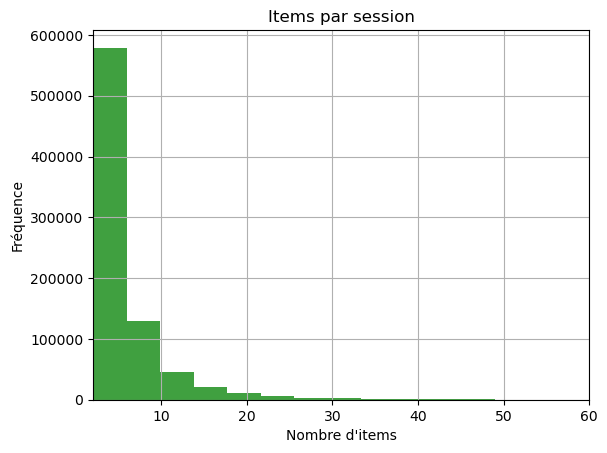

In [3]:
# Histogramme des sessions
# L’histogramme suivant illustre le nombre d’items par session.
# On retrouve 801744 sessions. 
count_list_session = []
for s in sessions:
    count_list_session.append(len(s))
    
n, bins, patches = plt.hist(count_list_session, 25, facecolor='g', alpha=0.75)
plt.xlabel("Nombre d'items")
plt.ylabel("Fréquence")
plt.title('Items par session')
plt.xlim(2, 60)
plt.grid(True)
plt.show()


In [4]:
# Entraînement :
# D’abord, on construit le fichier d’entraînement en ne préservant que les n-1 items 
# d’une séquence pour une session de n items. 

# Exemple: Pour la session 0, on a les items [1567, 26843, 11503].
# Ainsi, pour cette même session, on aura dans le fichier d'entraînement les items [1567, 26843]
train_X = []
for s in sessions:
    train_X.append(s[:-1])

# Validation
# Ensuite, on construit les fichiers de test et de validation comportant des séquences 
# constituées des items n-1 et n. Par la suite, on utilise l’item n-1 afin de générer 
# les prédictions du prochain item et ainsi vérifier si l’item n est inclus dans les prédictions. 
# Les données présentes dans le fichier de validation ne sont pas dans le fichier de test.

# Exemple: Pour la session 0, on a les items [1567, 26843, 11503].
# Ainsi, pour cette même session, on aura dans les fichiers de validation/test les items [26843, 11503]
validation = []
for s in sessions:
    validation.append(s[-2:])
    
# On génère des indexs aléatoires en validation et test    
size_vect = round(0.20 * len(sessions))
index = np.random.choice(range(len(validation)), size_vect * 2, replace=False)    

valid_X = np.array(validation)[index[:size_vect]].tolist()
test_X = np.array(validation)[index[size_vect:]].tolist()

In [5]:
# Dictionnaire contenant les hyperparamètres choisis pour 
# entraîner le modèle Word2vec
hyperparameters = {"vector_size" : 100, 
                   "min_count" : 1,
                   "epochs" : 5,
                   "workers" : 10,
                   "sg" : 1
                  }

def training_model_word2vec(data, params : dict):
    """
    Fonction entraînant un modèle Word2vec.
    On peut imaginer une session comme une phrase et les items 
    comme les mots de cette phrase. On créé le vocabulaire (ensemble du corpus) 
    à partir de toutes les données d’entraînement. Le modèle Word2vec se sert 
    de ce corpus pour apprendre les relations entre les items d’une session.

    Un modèle word2vec est un modèle de réseau de neurones simple comportant 
    qu’une seule couche cachée. À partir du fichier d’entraînement, on prend en 
    entrée un mot, et essaie de prédire le contexte des mots qui l’entourent 
    comme sortie. Dans notre cas, on utilise l’architecture CBOW 
    (Continuous Bag of Words)  pour construire notre modèle.

    Args:
        data: Une liste des sessions provenant du fichier d'entraînement.
        params: Un dictionnaire constitué des hyperparamètres utilisés.

    Returns:
        Le modèle entraîné.
    """
    model = Word2Vec(**params)
    model.build_vocab(data)
    model.train(data, 
                total_examples = model.corpus_count, 
                epochs = model.epochs, 
                compute_loss = True)
    
    return model

model = training_model_word2vec(train_X, params = hyperparameters)

In [6]:
# Exemple de sortie du top 10 des éléments suggérés en prenant 
# l’item n-1 (1567) du fichier de validation.
model.predict_output_word([1567], topn=10)

[(3751, 0.008274899),
 (22368, 0.007207536),
 (13745, 0.0054373797),
 (13510, 0.004423203),
 (19297, 0.0036915613),
 (4436, 0.0035465006),
 (7856, 0.003505795),
 (28077, 0.003035126),
 (14252, 0.0029822884),
 (5089, 0.002980184)]

In [7]:
def produce_list_top10(item):
    """
    Fonction produisant une liste de top 10 de meilleurs items
    suggérés. À partir de la méthode predict_output_word() appliquée 
    au modèle, on vient extraire les 10 meilleurs éléments. 

    Args:
        item: Le n-1 item provenant du fichier de validation.

    Returns:
        Une liste constituée des 10 meilleurs items suggérés pour
        le n-1-ème item du fichier de validation.
    """
    list_top10 = []
    for item in model.predict_output_word([item], topn=10):
        list_top10.append(item[0])
    return list_top10

def calculing_mrr(dataset):
    """
    Fonction mesurant la performance du modèle en calculant 
    le mean reciprocal rank (MRR). 
    
    Exemple: 
    Supposons que l’on ait une session comportant les items 
    suivants : [???, 10255, 5104] 
    On aurait donc une séquence d’items dans le fichier d’entraînement 
    telle que : [???, 10255] 
    On aurait donc une séquence d’items dans le fichier de validation 
    telle que : [10255, 5104] 

    On détermine le top 10 des éléments suggérés en prenant l’item n-1 (10255) 
    du fichier de validation. Ensuite, on vérifie si le dernier item (5104) 
    est présent dans ce top 10.  S’il est présent, on note son rang. 
    Dans cet exemple, puisque l’élément est en deuxième position, alors 
    on lui attribut un rang de 2. On procède de la sorte pour toutes les 
    sessions du fichier de validation. 
    
    Formule du MRR: MRR = 1/𝑄 ∑(𝑖 = 1 à 𝑄) 1/rangi 

    Args:
        dataset: Une liste de sessions des fichiers de validation et de test

    Returns:
        Un float. La mesure du mean reciprocal rank (MRR).
    """
    sum_rank = 0
    for i in dataset:
        if i[1] in produce_list_top10(i[0]):
            sum_rank += (1 / (produce_list_top10(i[0]).index(i[1])+1)) 
    MRR = sum_rank / len(dataset)      
    return MRR

In [8]:
print(calculing_mrr(valid_X))

0.28223196441998083


In [ ]:
print(calculing_mrr(test_X))

In [ ]:
model.init_sims(replace=True)
X = model.wv[model.wv.key_to_index]
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')